# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

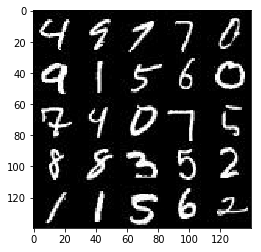

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

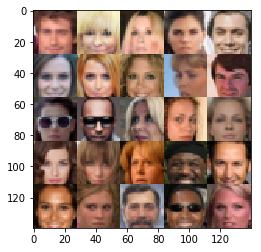

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, \
                        image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # First convolutional layer
        conv1 = tf.layers.conv2d(images, 56, 5, 2, 'SAME')
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        # Second convolutional layer
        conv2 = tf.layers.conv2d(conv1, 112, 5, 2, 'SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        # Third convolutional layer
        conv3 = tf.layers.conv2d(conv2, 224, 5, 2, 'SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        
        # Output fully connected layer
        flat   = tf.reshape(conv3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        
        logits = tf.layers.dropout(logits, rate=0.5)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # Input fully connected layer
        fully = tf.layers.dense(z, 7*7*112)
        fully = tf.reshape(fully, (-1, 7, 7, 112))
        fully = tf.layers.batch_normalization(fully, training=is_train)
        fully = tf.maximum(alpha*fully, fully)
        
        # First convolutional layer
        conv1 = tf.layers.conv2d_transpose(fully, 56, 5, 2, 'SAME')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        # Output convolutional layer
        conv2 = tf.layers.conv2d_transpose(conv1, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(conv2)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # G model
    g_model = generator(input_z, out_channel_dim)
    
    # D models
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean( \
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, \
        labels=tf.ones_like(d_logits_real)*np.random.uniform(0.7, 1.2)))
    d_loss_fake=tf.reduce_mean( \
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, \
        labels=tf.zeros_like(d_logits_fake)*np.random.uniform(0.0, 0.3)))
    d_loss = d_loss_real + d_loss_fake
    
    # G loss
    g_loss = tf.reduce_mean( \
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # run
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    print_every = 10
    show_every = 100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                steps += 1
                
                #### REVIEWER SUGGESTION ####
                # Normalize input to be between -1 and 1 to match generator's images
                batch_images = batch_images*2
                
                # Get input noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
            
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8331... Generator Loss: 2.8549
Epoch 1/2... Discriminator Loss: 2.4543... Generator Loss: 1.9468
Epoch 1/2... Discriminator Loss: 1.6502... Generator Loss: 2.7369
Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 1.6207
Epoch 1/2... Discriminator Loss: 1.6835... Generator Loss: 1.7157
Epoch 1/2... Discriminator Loss: 2.0206... Generator Loss: 2.5356
Epoch 1/2... Discriminator Loss: 1.4768... Generator Loss: 1.6739
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 1.8037
Epoch 1/2... Discriminator Loss: 1.5002... Generator Loss: 1.8719
Epoch 1/2... Discriminator Loss: 1.7073... Generator Loss: 2.5156


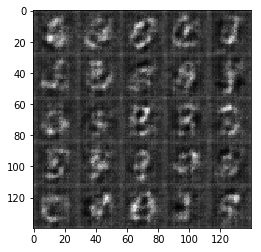

Epoch 1/2... Discriminator Loss: 1.6601... Generator Loss: 2.2302
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 1.4121
Epoch 1/2... Discriminator Loss: 1.0940... Generator Loss: 1.5009
Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 1.8274
Epoch 1/2... Discriminator Loss: 1.7457... Generator Loss: 2.2529
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 1.2325
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 1.5019
Epoch 1/2... Discriminator Loss: 1.0107... Generator Loss: 1.4940
Epoch 1/2... Discriminator Loss: 1.5946... Generator Loss: 2.0731
Epoch 1/2... Discriminator Loss: 1.6971... Generator Loss: 0.3253


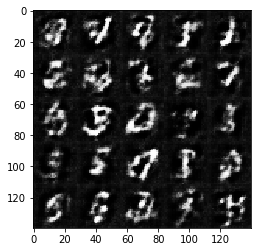

Epoch 1/2... Discriminator Loss: 1.5550... Generator Loss: 0.4140
Epoch 1/2... Discriminator Loss: 2.0617... Generator Loss: 0.2749
Epoch 1/2... Discriminator Loss: 2.0123... Generator Loss: 0.2592
Epoch 1/2... Discriminator Loss: 1.9218... Generator Loss: 0.2729
Epoch 1/2... Discriminator Loss: 1.8424... Generator Loss: 0.3371
Epoch 1/2... Discriminator Loss: 0.9213... Generator Loss: 1.1071
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 1.4690
Epoch 1/2... Discriminator Loss: 1.4757... Generator Loss: 0.4520
Epoch 1/2... Discriminator Loss: 1.1291... Generator Loss: 2.3152
Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 1.3721


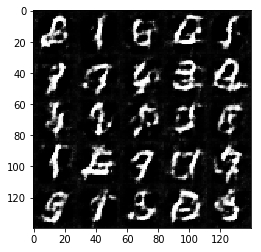

Epoch 1/2... Discriminator Loss: 1.7190... Generator Loss: 0.3965
Epoch 1/2... Discriminator Loss: 1.5433... Generator Loss: 0.3897
Epoch 1/2... Discriminator Loss: 1.8392... Generator Loss: 0.3197
Epoch 1/2... Discriminator Loss: 1.4594... Generator Loss: 0.4516
Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 0.5585
Epoch 1/2... Discriminator Loss: 1.4772... Generator Loss: 0.4466
Epoch 1/2... Discriminator Loss: 1.6594... Generator Loss: 2.2946
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 1.6481
Epoch 1/2... Discriminator Loss: 2.2307... Generator Loss: 0.2249
Epoch 1/2... Discriminator Loss: 1.9070... Generator Loss: 0.2710


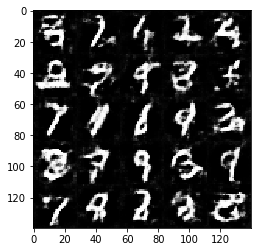

Epoch 1/2... Discriminator Loss: 1.8311... Generator Loss: 0.3005
Epoch 1/2... Discriminator Loss: 1.1926... Generator Loss: 0.6413
Epoch 1/2... Discriminator Loss: 1.5527... Generator Loss: 0.4153
Epoch 1/2... Discriminator Loss: 1.9746... Generator Loss: 0.2828
Epoch 1/2... Discriminator Loss: 1.2327... Generator Loss: 0.7889
Epoch 1/2... Discriminator Loss: 1.9015... Generator Loss: 0.2862
Epoch 1/2... Discriminator Loss: 2.3879... Generator Loss: 0.1734
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 2.0205
Epoch 1/2... Discriminator Loss: 1.3297... Generator Loss: 1.7901
Epoch 1/2... Discriminator Loss: 1.0782... Generator Loss: 1.2608


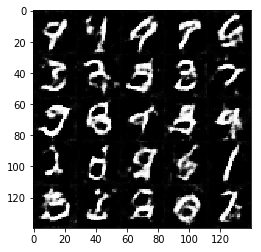

Epoch 1/2... Discriminator Loss: 1.0119... Generator Loss: 1.7398
Epoch 1/2... Discriminator Loss: 0.9369... Generator Loss: 1.4629
Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 1.4905
Epoch 1/2... Discriminator Loss: 1.1568... Generator Loss: 0.7315
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 1.4593
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 2.1822
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 1.3283
Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 1.5189
Epoch 1/2... Discriminator Loss: 0.9555... Generator Loss: 1.2374
Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 0.4916


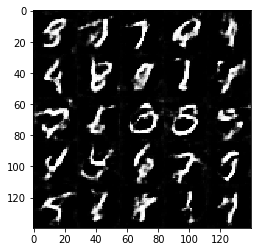

Epoch 1/2... Discriminator Loss: 1.4069... Generator Loss: 3.0701
Epoch 1/2... Discriminator Loss: 1.2080... Generator Loss: 1.9003
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 2.0923
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 0.7849
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.5450
Epoch 1/2... Discriminator Loss: 1.7386... Generator Loss: 2.6781
Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 1.0414
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.5275
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 0.5372
Epoch 1/2... Discriminator Loss: 1.8597... Generator Loss: 0.2950


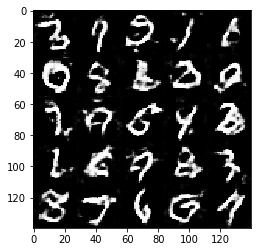

Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 1.1528
Epoch 1/2... Discriminator Loss: 1.5443... Generator Loss: 2.3156
Epoch 1/2... Discriminator Loss: 0.9692... Generator Loss: 2.1539
Epoch 1/2... Discriminator Loss: 0.9058... Generator Loss: 1.8570
Epoch 1/2... Discriminator Loss: 1.0297... Generator Loss: 1.7794
Epoch 1/2... Discriminator Loss: 0.9954... Generator Loss: 1.0114
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.5640
Epoch 1/2... Discriminator Loss: 2.1420... Generator Loss: 0.2471
Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 0.5796
Epoch 1/2... Discriminator Loss: 1.0751... Generator Loss: 0.8587


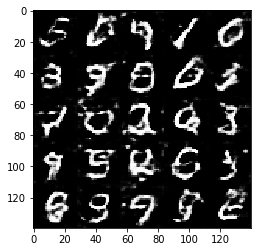

Epoch 1/2... Discriminator Loss: 2.0541... Generator Loss: 0.2568
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 1.9183
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 2.2946
Epoch 1/2... Discriminator Loss: 1.4885... Generator Loss: 0.4386
Epoch 1/2... Discriminator Loss: 1.6519... Generator Loss: 0.3929
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 0.7746
Epoch 1/2... Discriminator Loss: 1.5790... Generator Loss: 0.4322
Epoch 1/2... Discriminator Loss: 0.8475... Generator Loss: 1.3451
Epoch 1/2... Discriminator Loss: 0.9228... Generator Loss: 1.8541
Epoch 1/2... Discriminator Loss: 0.8110... Generator Loss: 1.8165


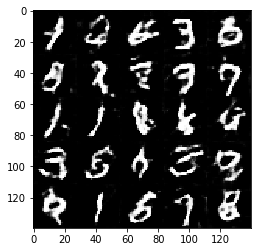

Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 0.5466
Epoch 1/2... Discriminator Loss: 1.6266... Generator Loss: 0.4358
Epoch 1/2... Discriminator Loss: 1.4720... Generator Loss: 0.5068
Epoch 1/2... Discriminator Loss: 1.3110... Generator Loss: 0.6528
Epoch 1/2... Discriminator Loss: 0.9026... Generator Loss: 1.1810
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 1.8400
Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 1.6721
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 1.3975
Epoch 1/2... Discriminator Loss: 1.0014... Generator Loss: 1.6509
Epoch 1/2... Discriminator Loss: 1.4409... Generator Loss: 0.4702


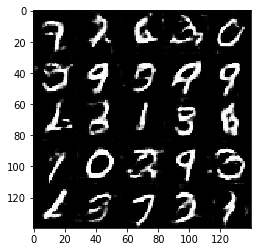

Epoch 1/2... Discriminator Loss: 1.7262... Generator Loss: 0.3328
Epoch 1/2... Discriminator Loss: 1.5509... Generator Loss: 0.4607
Epoch 1/2... Discriminator Loss: 1.5222... Generator Loss: 0.6280
Epoch 1/2... Discriminator Loss: 1.4247... Generator Loss: 0.5505
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.5509
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 0.7177
Epoch 1/2... Discriminator Loss: 1.9611... Generator Loss: 0.3340
Epoch 1/2... Discriminator Loss: 1.7182... Generator Loss: 0.3867
Epoch 1/2... Discriminator Loss: 1.1712... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.6007


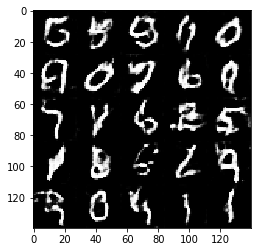

Epoch 1/2... Discriminator Loss: 1.7957... Generator Loss: 3.2625
Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 1.7092
Epoch 1/2... Discriminator Loss: 2.0054... Generator Loss: 0.3359
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 2.0295
Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 0.8885
Epoch 1/2... Discriminator Loss: 1.8600... Generator Loss: 0.3368
Epoch 1/2... Discriminator Loss: 1.0066... Generator Loss: 0.9022
Epoch 1/2... Discriminator Loss: 0.8188... Generator Loss: 1.4080
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 1.0191
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 2.3878


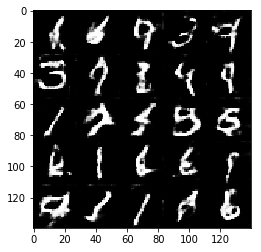

Epoch 1/2... Discriminator Loss: 0.8012... Generator Loss: 2.4225
Epoch 1/2... Discriminator Loss: 0.8606... Generator Loss: 1.0606
Epoch 1/2... Discriminator Loss: 0.7415... Generator Loss: 1.3300
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 2.0191
Epoch 1/2... Discriminator Loss: 1.0768... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 0.6429... Generator Loss: 1.6360
Epoch 1/2... Discriminator Loss: 1.0566... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 2.2365... Generator Loss: 3.9623
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 2.4336
Epoch 1/2... Discriminator Loss: 0.9437... Generator Loss: 0.9666


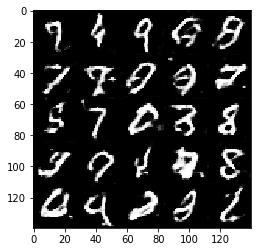

Epoch 1/2... Discriminator Loss: 1.0432... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 0.9863... Generator Loss: 0.8666
Epoch 1/2... Discriminator Loss: 0.7707... Generator Loss: 1.3264
Epoch 1/2... Discriminator Loss: 1.7709... Generator Loss: 2.9002
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 1.2602
Epoch 1/2... Discriminator Loss: 1.1649... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 0.7263
Epoch 1/2... Discriminator Loss: 2.4355... Generator Loss: 0.2168
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.6227
Epoch 1/2... Discriminator Loss: 0.6835... Generator Loss: 2.2005


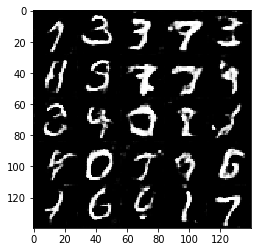

Epoch 1/2... Discriminator Loss: 1.3031... Generator Loss: 0.5844
Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 0.8922... Generator Loss: 1.4673
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 1.5061
Epoch 1/2... Discriminator Loss: 0.8599... Generator Loss: 1.0702
Epoch 1/2... Discriminator Loss: 1.6505... Generator Loss: 0.4250
Epoch 1/2... Discriminator Loss: 1.0253... Generator Loss: 0.8628
Epoch 1/2... Discriminator Loss: 1.8484... Generator Loss: 0.3703
Epoch 1/2... Discriminator Loss: 2.3017... Generator Loss: 0.2647
Epoch 1/2... Discriminator Loss: 2.0893... Generator Loss: 0.2708


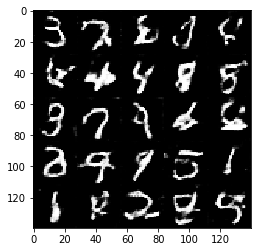

Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 0.6357
Epoch 1/2... Discriminator Loss: 1.2883... Generator Loss: 0.6128
Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 1.1442
Epoch 1/2... Discriminator Loss: 0.6800... Generator Loss: 1.9704
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 0.8387
Epoch 1/2... Discriminator Loss: 2.2553... Generator Loss: 0.1968
Epoch 1/2... Discriminator Loss: 1.0407... Generator Loss: 0.8229
Epoch 1/2... Discriminator Loss: 1.3711... Generator Loss: 0.5423
Epoch 1/2... Discriminator Loss: 1.7435... Generator Loss: 0.4386
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 1.0047


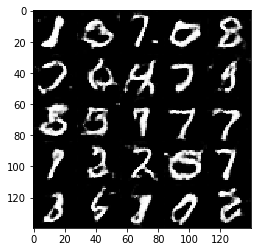

Epoch 1/2... Discriminator Loss: 1.7455... Generator Loss: 0.4876
Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 0.7168
Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 1.1924
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 1.8648
Epoch 1/2... Discriminator Loss: 0.8668... Generator Loss: 1.2795
Epoch 1/2... Discriminator Loss: 0.7912... Generator Loss: 1.2694
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 0.9041
Epoch 1/2... Discriminator Loss: 1.1115... Generator Loss: 0.9293
Epoch 1/2... Discriminator Loss: 1.2407... Generator Loss: 2.9891
Epoch 1/2... Discriminator Loss: 1.1255... Generator Loss: 0.7575


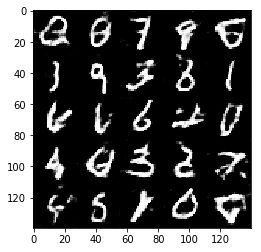

Epoch 1/2... Discriminator Loss: 0.9699... Generator Loss: 1.1012
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 0.6280
Epoch 1/2... Discriminator Loss: 0.7436... Generator Loss: 1.5552
Epoch 1/2... Discriminator Loss: 0.7271... Generator Loss: 1.4253
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 1.1447
Epoch 1/2... Discriminator Loss: 2.5096... Generator Loss: 0.2436
Epoch 1/2... Discriminator Loss: 1.3704... Generator Loss: 0.5926
Epoch 1/2... Discriminator Loss: 1.8205... Generator Loss: 0.4981
Epoch 1/2... Discriminator Loss: 0.8734... Generator Loss: 1.2308
Epoch 1/2... Discriminator Loss: 0.6869... Generator Loss: 1.7929


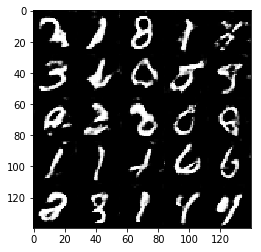

Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.6320
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 1.9722
Epoch 1/2... Discriminator Loss: 0.7101... Generator Loss: 1.4411
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 0.9125
Epoch 1/2... Discriminator Loss: 1.2968... Generator Loss: 0.6899
Epoch 1/2... Discriminator Loss: 3.0705... Generator Loss: 0.1203
Epoch 1/2... Discriminator Loss: 1.5640... Generator Loss: 0.4309
Epoch 2/2... Discriminator Loss: 1.3230... Generator Loss: 0.5580
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.5578
Epoch 2/2... Discriminator Loss: 0.6096... Generator Loss: 1.8988


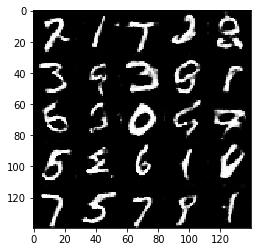

Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.2208
Epoch 2/2... Discriminator Loss: 2.5493... Generator Loss: 0.1643
Epoch 2/2... Discriminator Loss: 0.7819... Generator Loss: 2.1334
Epoch 2/2... Discriminator Loss: 0.7856... Generator Loss: 1.4616
Epoch 2/2... Discriminator Loss: 1.4892... Generator Loss: 0.5616
Epoch 2/2... Discriminator Loss: 0.6590... Generator Loss: 1.5707
Epoch 2/2... Discriminator Loss: 0.6988... Generator Loss: 1.4311
Epoch 2/2... Discriminator Loss: 1.1621... Generator Loss: 0.9427
Epoch 2/2... Discriminator Loss: 0.6434... Generator Loss: 1.5382
Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 1.8731


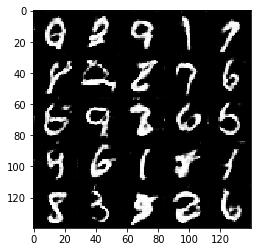

Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 0.8313
Epoch 2/2... Discriminator Loss: 0.8259... Generator Loss: 1.2975
Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.4556
Epoch 2/2... Discriminator Loss: 1.5976... Generator Loss: 0.5606
Epoch 2/2... Discriminator Loss: 0.6152... Generator Loss: 2.0864
Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 1.5757
Epoch 2/2... Discriminator Loss: 0.6312... Generator Loss: 1.7208
Epoch 2/2... Discriminator Loss: 2.0357... Generator Loss: 0.3801
Epoch 2/2... Discriminator Loss: 1.1379... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 1.1285


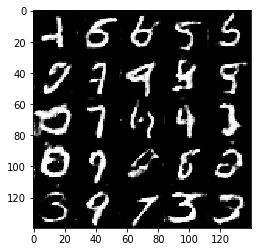

Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 2.5643
Epoch 2/2... Discriminator Loss: 1.5412... Generator Loss: 0.5251
Epoch 2/2... Discriminator Loss: 0.6750... Generator Loss: 2.0554
Epoch 2/2... Discriminator Loss: 0.6789... Generator Loss: 1.4475
Epoch 2/2... Discriminator Loss: 1.4877... Generator Loss: 2.7486
Epoch 2/2... Discriminator Loss: 1.4359... Generator Loss: 0.5274
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 2.3192
Epoch 2/2... Discriminator Loss: 0.9654... Generator Loss: 1.0177
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 1.0407
Epoch 2/2... Discriminator Loss: 2.1201... Generator Loss: 0.3368


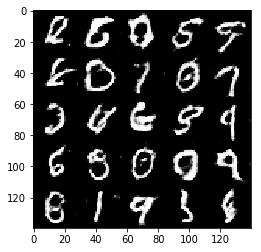

Epoch 2/2... Discriminator Loss: 1.0196... Generator Loss: 0.8969
Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 1.2362
Epoch 2/2... Discriminator Loss: 0.5503... Generator Loss: 1.9847
Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 0.5696
Epoch 2/2... Discriminator Loss: 1.9552... Generator Loss: 0.4530
Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 1.4371
Epoch 2/2... Discriminator Loss: 2.3313... Generator Loss: 0.2908
Epoch 2/2... Discriminator Loss: 1.5827... Generator Loss: 0.5065
Epoch 2/2... Discriminator Loss: 0.8436... Generator Loss: 2.0419
Epoch 2/2... Discriminator Loss: 1.5389... Generator Loss: 0.4631


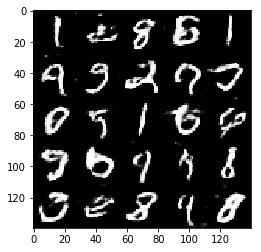

Epoch 2/2... Discriminator Loss: 0.8540... Generator Loss: 1.2962
Epoch 2/2... Discriminator Loss: 0.7527... Generator Loss: 1.4665
Epoch 2/2... Discriminator Loss: 1.0700... Generator Loss: 0.9128
Epoch 2/2... Discriminator Loss: 0.6400... Generator Loss: 1.5395
Epoch 2/2... Discriminator Loss: 0.8305... Generator Loss: 1.8007
Epoch 2/2... Discriminator Loss: 0.7889... Generator Loss: 1.2940
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 0.6531
Epoch 2/2... Discriminator Loss: 0.7196... Generator Loss: 1.7187
Epoch 2/2... Discriminator Loss: 2.1033... Generator Loss: 5.7877
Epoch 2/2... Discriminator Loss: 0.8243... Generator Loss: 1.2349


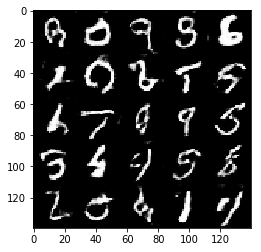

Epoch 2/2... Discriminator Loss: 1.1485... Generator Loss: 0.7563
Epoch 2/2... Discriminator Loss: 0.6529... Generator Loss: 1.6849
Epoch 2/2... Discriminator Loss: 1.1564... Generator Loss: 0.7775
Epoch 2/2... Discriminator Loss: 0.6981... Generator Loss: 1.4918
Epoch 2/2... Discriminator Loss: 2.1709... Generator Loss: 3.9319
Epoch 2/2... Discriminator Loss: 0.8407... Generator Loss: 1.1168
Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 0.9766
Epoch 2/2... Discriminator Loss: 1.1831... Generator Loss: 0.8658
Epoch 2/2... Discriminator Loss: 1.3397... Generator Loss: 0.6562
Epoch 2/2... Discriminator Loss: 1.6679... Generator Loss: 0.4564


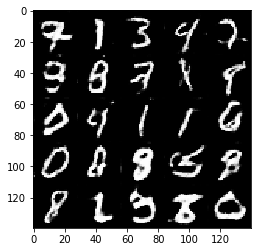

Epoch 2/2... Discriminator Loss: 0.7234... Generator Loss: 1.4592
Epoch 2/2... Discriminator Loss: 0.8208... Generator Loss: 1.8270
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 0.6782
Epoch 2/2... Discriminator Loss: 1.6720... Generator Loss: 0.5602
Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 2.6249
Epoch 2/2... Discriminator Loss: 0.8513... Generator Loss: 1.2774
Epoch 2/2... Discriminator Loss: 0.8984... Generator Loss: 1.0664
Epoch 2/2... Discriminator Loss: 1.0729... Generator Loss: 2.8518
Epoch 2/2... Discriminator Loss: 0.6285... Generator Loss: 1.6243
Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 1.1849


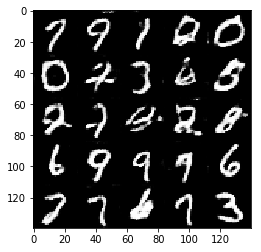

Epoch 2/2... Discriminator Loss: 1.1100... Generator Loss: 3.4375
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 0.6579
Epoch 2/2... Discriminator Loss: 1.0154... Generator Loss: 0.8977
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.0424
Epoch 2/2... Discriminator Loss: 2.0807... Generator Loss: 0.3420
Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.4838
Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 1.4358... Generator Loss: 0.6182
Epoch 2/2... Discriminator Loss: 0.6250... Generator Loss: 1.7567
Epoch 2/2... Discriminator Loss: 0.8834... Generator Loss: 1.0422


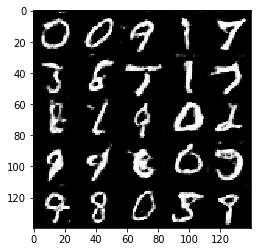

Epoch 2/2... Discriminator Loss: 0.5974... Generator Loss: 1.7314
Epoch 2/2... Discriminator Loss: 1.7702... Generator Loss: 0.4405
Epoch 2/2... Discriminator Loss: 0.8224... Generator Loss: 1.2450
Epoch 2/2... Discriminator Loss: 0.7332... Generator Loss: 1.4973
Epoch 2/2... Discriminator Loss: 2.5268... Generator Loss: 4.4555
Epoch 2/2... Discriminator Loss: 1.7946... Generator Loss: 0.4602
Epoch 2/2... Discriminator Loss: 1.5722... Generator Loss: 0.5685
Epoch 2/2... Discriminator Loss: 0.8623... Generator Loss: 1.8345
Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 3.8130
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 0.7301


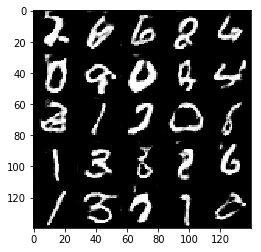

Epoch 2/2... Discriminator Loss: 0.7442... Generator Loss: 1.4269
Epoch 2/2... Discriminator Loss: 1.0211... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 0.7403... Generator Loss: 1.3812
Epoch 2/2... Discriminator Loss: 1.7589... Generator Loss: 0.4066
Epoch 2/2... Discriminator Loss: 1.0741... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 0.7184... Generator Loss: 1.5943
Epoch 2/2... Discriminator Loss: 0.7671... Generator Loss: 1.3681
Epoch 2/2... Discriminator Loss: 1.2709... Generator Loss: 0.8168
Epoch 2/2... Discriminator Loss: 0.5847... Generator Loss: 2.1510
Epoch 2/2... Discriminator Loss: 0.8395... Generator Loss: 1.1917


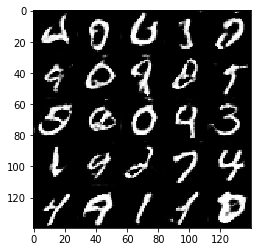

Epoch 2/2... Discriminator Loss: 0.9756... Generator Loss: 0.9802
Epoch 2/2... Discriminator Loss: 0.6863... Generator Loss: 1.6776
Epoch 2/2... Discriminator Loss: 1.4530... Generator Loss: 0.5889
Epoch 2/2... Discriminator Loss: 0.5597... Generator Loss: 2.2572
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 3.0374
Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 0.9191
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 2.5834
Epoch 2/2... Discriminator Loss: 1.0702... Generator Loss: 0.8121
Epoch 2/2... Discriminator Loss: 0.8432... Generator Loss: 1.0910
Epoch 2/2... Discriminator Loss: 0.7121... Generator Loss: 1.4114


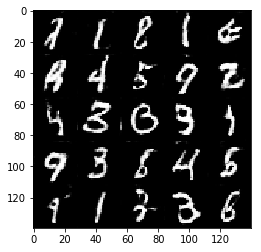

Epoch 2/2... Discriminator Loss: 0.7023... Generator Loss: 1.4786
Epoch 2/2... Discriminator Loss: 2.2257... Generator Loss: 0.3223
Epoch 2/2... Discriminator Loss: 0.8758... Generator Loss: 1.1128
Epoch 2/2... Discriminator Loss: 0.6490... Generator Loss: 1.6122
Epoch 2/2... Discriminator Loss: 0.7311... Generator Loss: 1.4066
Epoch 2/2... Discriminator Loss: 0.5221... Generator Loss: 2.1440
Epoch 2/2... Discriminator Loss: 0.6936... Generator Loss: 1.6981
Epoch 2/2... Discriminator Loss: 1.7420... Generator Loss: 4.0183
Epoch 2/2... Discriminator Loss: 0.6261... Generator Loss: 2.0057
Epoch 2/2... Discriminator Loss: 1.5813... Generator Loss: 0.4942


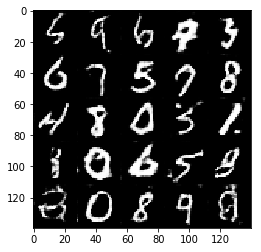

Epoch 2/2... Discriminator Loss: 0.8642... Generator Loss: 1.0739
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 0.8470
Epoch 2/2... Discriminator Loss: 0.7503... Generator Loss: 1.8194
Epoch 2/2... Discriminator Loss: 0.7140... Generator Loss: 1.3941
Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 2.3478... Generator Loss: 0.2751
Epoch 2/2... Discriminator Loss: 0.6676... Generator Loss: 1.5421
Epoch 2/2... Discriminator Loss: 1.1004... Generator Loss: 0.8994
Epoch 2/2... Discriminator Loss: 0.6246... Generator Loss: 1.6279
Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 1.0240


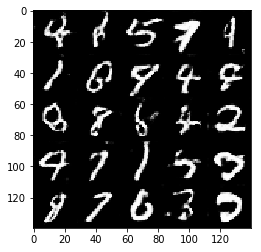

Epoch 2/2... Discriminator Loss: 0.7566... Generator Loss: 1.2645
Epoch 2/2... Discriminator Loss: 0.5846... Generator Loss: 1.7890
Epoch 2/2... Discriminator Loss: 0.6079... Generator Loss: 1.8714
Epoch 2/2... Discriminator Loss: 1.5728... Generator Loss: 0.5151
Epoch 2/2... Discriminator Loss: 2.1532... Generator Loss: 0.3261
Epoch 2/2... Discriminator Loss: 1.3091... Generator Loss: 0.6094
Epoch 2/2... Discriminator Loss: 1.8709... Generator Loss: 0.3158
Epoch 2/2... Discriminator Loss: 1.7928... Generator Loss: 0.5125
Epoch 2/2... Discriminator Loss: 0.9750... Generator Loss: 0.9109
Epoch 2/2... Discriminator Loss: 1.9004... Generator Loss: 0.3524


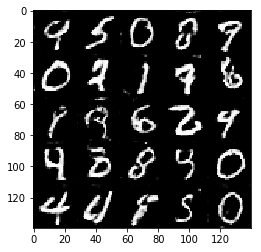

Epoch 2/2... Discriminator Loss: 0.7690... Generator Loss: 1.2276
Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 0.8299
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.0153
Epoch 2/2... Discriminator Loss: 0.7404... Generator Loss: 1.4225
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.6218
Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 0.8555
Epoch 2/2... Discriminator Loss: 0.8633... Generator Loss: 3.0383
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 0.8447
Epoch 2/2... Discriminator Loss: 0.8197... Generator Loss: 1.3410
Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 0.6750


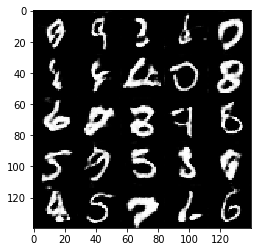

Epoch 2/2... Discriminator Loss: 0.7271... Generator Loss: 1.3814
Epoch 2/2... Discriminator Loss: 2.3717... Generator Loss: 0.3167
Epoch 2/2... Discriminator Loss: 0.8149... Generator Loss: 1.2033
Epoch 2/2... Discriminator Loss: 1.0690... Generator Loss: 0.9439
Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 0.5787
Epoch 2/2... Discriminator Loss: 0.8756... Generator Loss: 1.1220
Epoch 2/2... Discriminator Loss: 0.6518... Generator Loss: 1.4885
Epoch 2/2... Discriminator Loss: 0.9396... Generator Loss: 1.0478
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 2.1930
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 0.5732


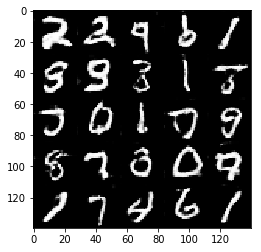

Epoch 2/2... Discriminator Loss: 1.3374... Generator Loss: 0.7815
Epoch 2/2... Discriminator Loss: 1.6120... Generator Loss: 0.4338
Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 0.7035
Epoch 2/2... Discriminator Loss: 1.3202... Generator Loss: 0.6817
Epoch 2/2... Discriminator Loss: 0.6877... Generator Loss: 2.0658
Epoch 2/2... Discriminator Loss: 1.7141... Generator Loss: 0.5575
Epoch 2/2... Discriminator Loss: 0.7250... Generator Loss: 1.3568
Epoch 2/2... Discriminator Loss: 1.5697... Generator Loss: 3.6112
Epoch 2/2... Discriminator Loss: 1.5095... Generator Loss: 0.6632
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 1.1913


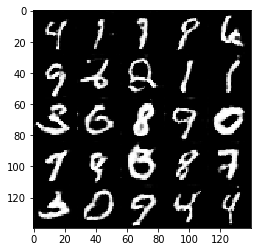

Epoch 2/2... Discriminator Loss: 0.7176... Generator Loss: 1.4855
Epoch 2/2... Discriminator Loss: 0.8407... Generator Loss: 3.1434
Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 1.2950
Epoch 2/2... Discriminator Loss: 1.1432... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 0.5388... Generator Loss: 1.9636
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 1.5843
Epoch 2/2... Discriminator Loss: 0.7226... Generator Loss: 1.3893
Epoch 2/2... Discriminator Loss: 0.6415... Generator Loss: 1.9428
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.5592
Epoch 2/2... Discriminator Loss: 1.7779... Generator Loss: 0.4752


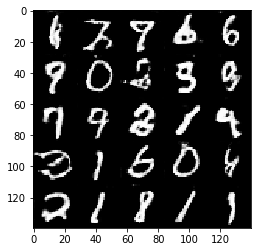

Epoch 2/2... Discriminator Loss: 1.3223... Generator Loss: 0.7891
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.7054
Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 1.0086
Epoch 2/2... Discriminator Loss: 0.6183... Generator Loss: 1.6979
Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 1.0030


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.9446... Generator Loss: 0.1128
Epoch 1/1... Discriminator Loss: 2.6244... Generator Loss: 4.0936
Epoch 1/1... Discriminator Loss: 1.8270... Generator Loss: 3.2786
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.7126
Epoch 1/1... Discriminator Loss: 1.5639... Generator Loss: 2.3190
Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 1.5543
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 2.2908
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.6944
Epoch 1/1... Discriminator Loss: 1.6110... Generator Loss: 0.4648


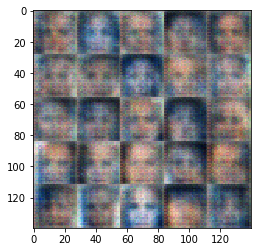

Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.3712
Epoch 1/1... Discriminator Loss: 1.8409... Generator Loss: 0.3653
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 1.7260
Epoch 1/1... Discriminator Loss: 1.7809... Generator Loss: 0.4036
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 1.4020
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 1.3886
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 1.3158
Epoch 1/1... Discriminator Loss: 2.0462... Generator Loss: 0.2878
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.5085


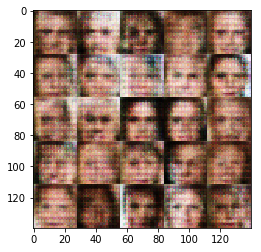

Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.9104... Generator Loss: 2.7136
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 2.2580... Generator Loss: 1.6399


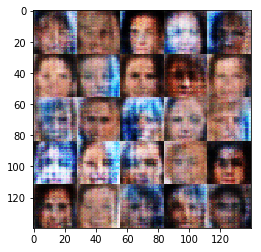

Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 2.2523... Generator Loss: 0.2128
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.5907
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.9357


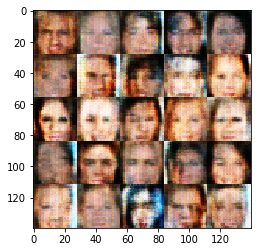

Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 1.2403
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.1748


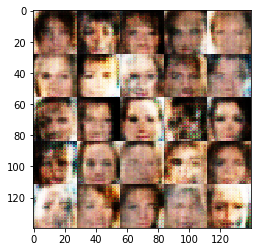

Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.6142
Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 1.9373
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.9513


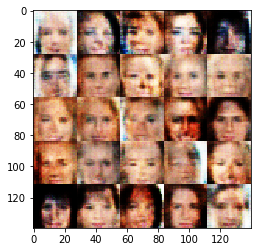

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 1.0319


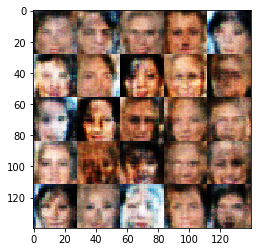

Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.3547
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.6733... Generator Loss: 0.4367
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.9406
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.6304


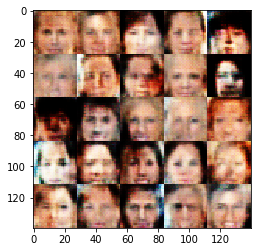

Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 1.5705
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 2.8615... Generator Loss: 3.2845
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 1.0392


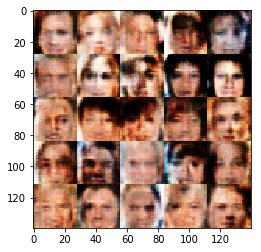

Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 1.2124
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.3915
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 1.3525
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.8992... Generator Loss: 1.8997


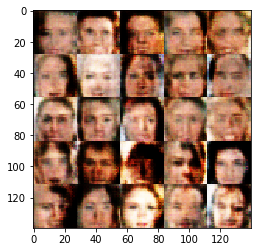

Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.2975
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 1.1540
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8124


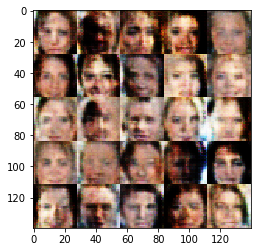

Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 1.3539
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 1.9708
Epoch 1/1... Discriminator Loss: 1.7049... Generator Loss: 1.8065
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 1.5015
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.8126


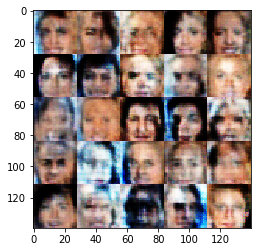

Epoch 1/1... Discriminator Loss: 1.8682... Generator Loss: 0.3344
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.3576
Epoch 1/1... Discriminator Loss: 3.4966... Generator Loss: 3.4645
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 1.0139


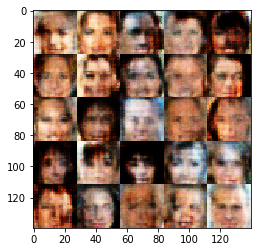

Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 1.3240


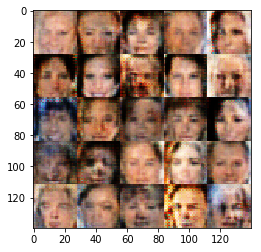

Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.3167
Epoch 1/1... Discriminator Loss: 1.6855... Generator Loss: 0.4227
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 2.0931... Generator Loss: 2.3928
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 1.0776
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 1.1913


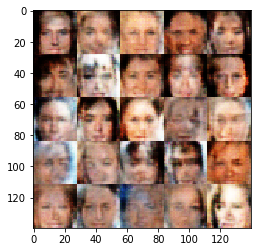

Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 1.5075
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.5292


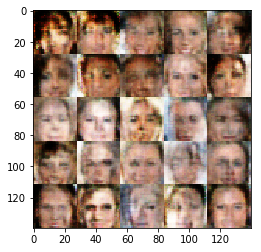

Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 1.5945
Epoch 1/1... Discriminator Loss: 1.9932... Generator Loss: 1.5932
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.1078


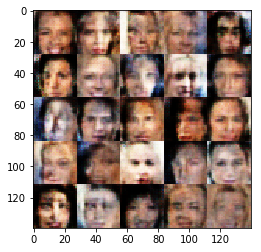

Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 1.6204... Generator Loss: 0.4462


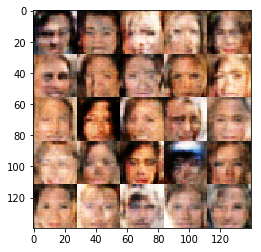

Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 2.2110
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 1.3301
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.5206
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.9576... Generator Loss: 0.3100
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.9015


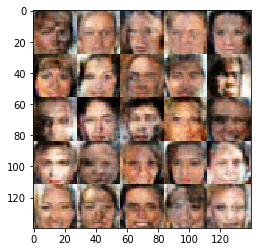

Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 1.5387
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 1.1958
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 1.6794... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 1.1082
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 1.3461
Epoch 1/1... Discriminator Loss: 1.5804... Generator Loss: 0.4891


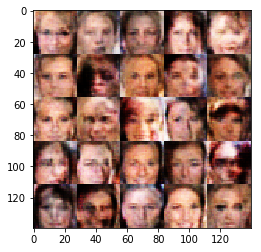

Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.9940


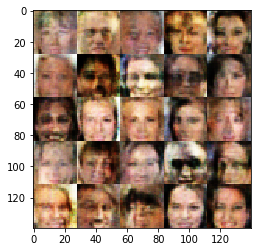

Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 2.5713... Generator Loss: 2.9167
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 1.2769
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 1.4612
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 1.3042


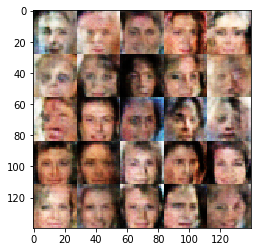

Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 1.2665
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 1.2926
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.6550... Generator Loss: 0.4493
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.9588


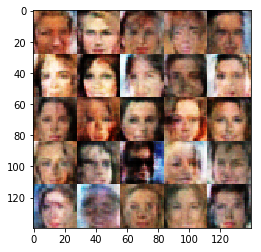

Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 1.2375
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 1.1848
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.7365... Generator Loss: 0.4268
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.4282


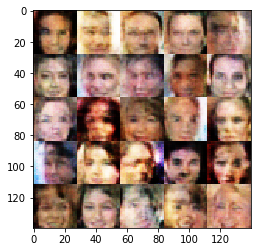

Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.0281


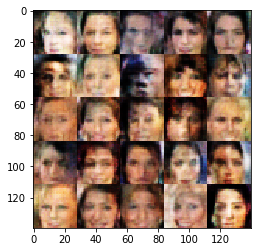

Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 1.3045
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 1.6032


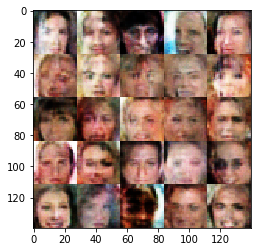

Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 2.0514... Generator Loss: 0.2615
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.3673
Epoch 1/1... Discriminator Loss: 2.0130... Generator Loss: 0.2818
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 1.2985
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.7560


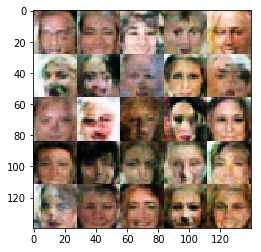

Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.7023... Generator Loss: 0.4303
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.2216


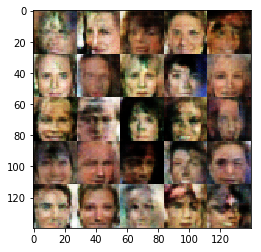

Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 1.4547
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.5796


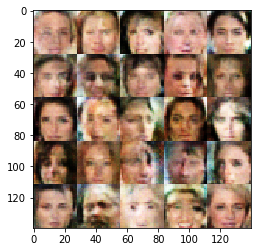

Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 1.4577
Epoch 1/1... Discriminator Loss: 2.3917... Generator Loss: 0.2083
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.9009


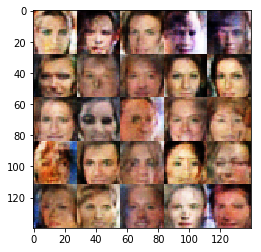

Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.8074... Generator Loss: 0.3600
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 1.2597
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 1.4878
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7784


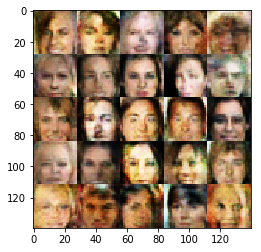

Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 1.3540
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 1.3499
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.2422
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.9415


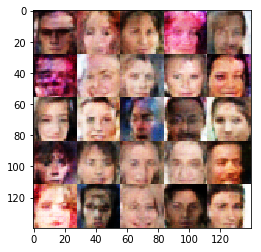

Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.8682... Generator Loss: 0.3436
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.8415
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.5021


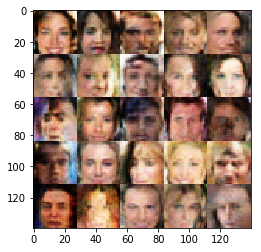

Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.6717... Generator Loss: 0.4104
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.3335
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.3974
Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.4304
Epoch 1/1... Discriminator Loss: 1.6433... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.4456
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.5915


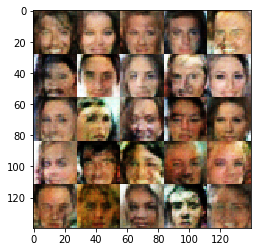

Epoch 1/1... Discriminator Loss: 1.6591... Generator Loss: 0.4800
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.7091... Generator Loss: 0.4023
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 1.6663
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.6828... Generator Loss: 0.4170


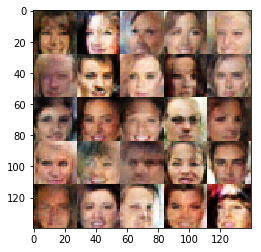

Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.2185
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.2638
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.8379... Generator Loss: 1.9863
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.7997


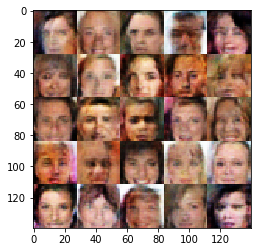

Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.1559
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.1321
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.9286


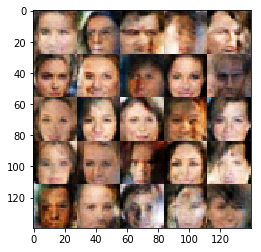

Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.6099... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 1.6849
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.3454
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 1.8241
Epoch 1/1... Discriminator Loss: 1.7092... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 1.5691


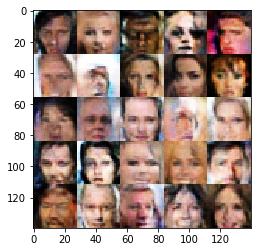

Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.3026
Epoch 1/1... Discriminator Loss: 1.9294... Generator Loss: 2.6698
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 1.3933
Epoch 1/1... Discriminator Loss: 1.8244... Generator Loss: 0.3628


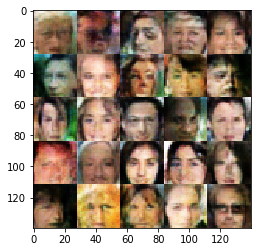

Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 1.2691
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.9430... Generator Loss: 0.3614
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.9274... Generator Loss: 0.3368
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 2.0622... Generator Loss: 0.2881


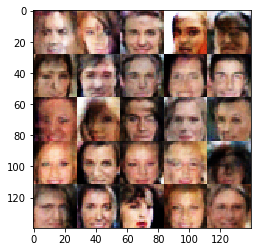

Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.6550
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.3583
Epoch 1/1... Discriminator Loss: 1.6637... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.6044... Generator Loss: 0.4574
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.5097


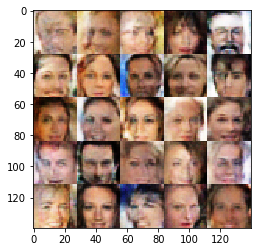

Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 1.4115
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 1.6625
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 1.5952
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.4821
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 1.2942


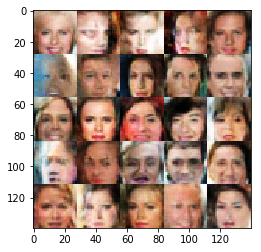

Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 1.2691
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 2.0662... Generator Loss: 0.2815
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.7294... Generator Loss: 0.4072


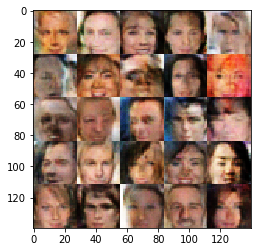

Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.1267
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.4002
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 1.6301
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 1.4290
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.3282


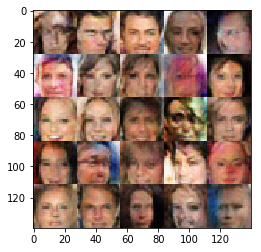

Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.7439... Generator Loss: 0.4384
Epoch 1/1... Discriminator Loss: 1.6836... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 1.6194
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 2.0250... Generator Loss: 0.3094


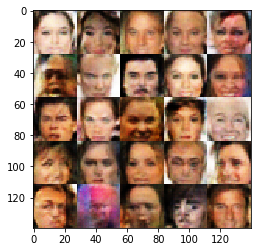

Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 1.3480
Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.6668


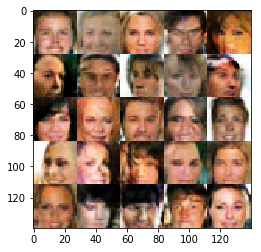

Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.6631... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 1.8261
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.2981
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.8556
Epoch 1/1... Discriminator Loss: 1.9258... Generator Loss: 0.3763
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 2.1273


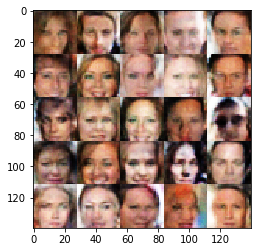

Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 1.4444
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 1.5715... Generator Loss: 2.2174
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 1.5307
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.9349


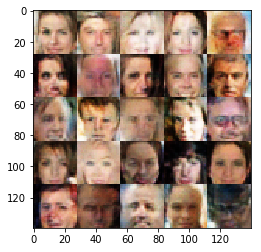

Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 1.2398
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.8202... Generator Loss: 0.4238
Epoch 1/1... Discriminator Loss: 1.8074... Generator Loss: 0.3808
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.3305
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.0418


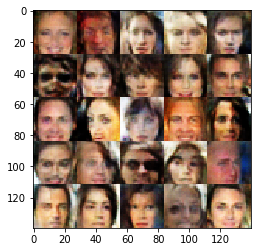

Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 1.6823
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 1.1571
Epoch 1/1... Discriminator Loss: 1.6644... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.3921


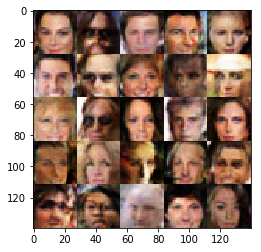

Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.7401... Generator Loss: 0.4223
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.6224


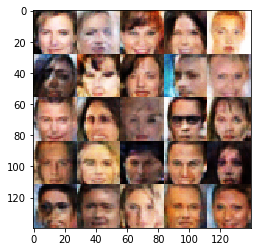

Epoch 1/1... Discriminator Loss: 1.7194... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 1.4666
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 1.2097
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 1.8136
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.3784
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 1.3607


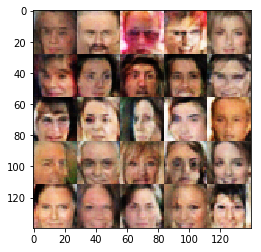

Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.2742
Epoch 1/1... Discriminator Loss: 2.1037... Generator Loss: 0.2846
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.5970... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.8969


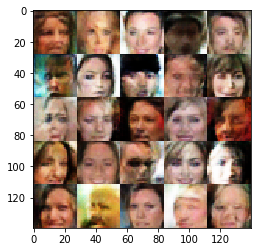

Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.6889... Generator Loss: 0.4400
Epoch 1/1... Discriminator Loss: 1.7118... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 1.6231
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.6743... Generator Loss: 0.4173
Epoch 1/1... Discriminator Loss: 1.5938... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.5895


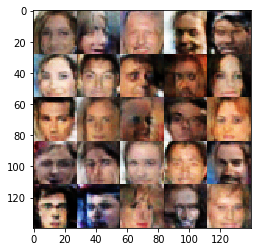

Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.4154
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.9589


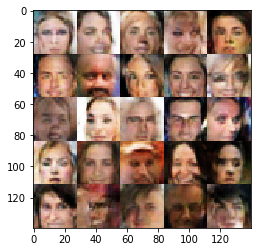

Epoch 1/1... Discriminator Loss: 1.8293... Generator Loss: 0.3693
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.1434
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 1.3721
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.5461


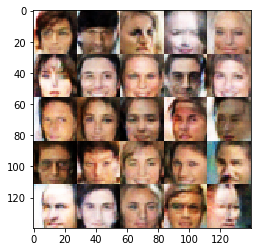

Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 1.6824
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.1683
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.8757


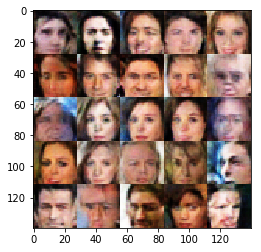

Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.4549
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.8361
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.4521
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7212


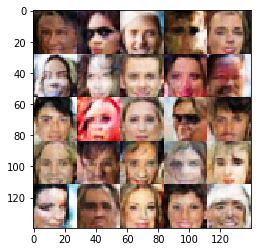

Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.2549
Epoch 1/1... Discriminator Loss: 1.6301... Generator Loss: 2.0307
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.4637
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.7200


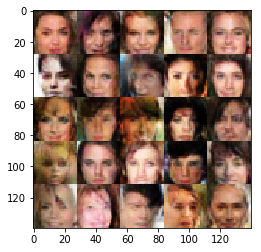

Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.6358
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.1139
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.9262
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6109


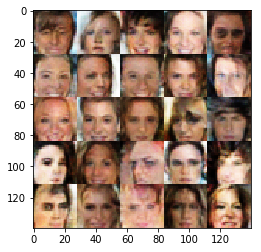

Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 1.8813
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 2.4437
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.2705
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.6605
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.2521
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.6896


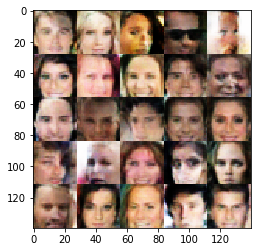

Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.5082
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.7056
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 1.3884
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6002


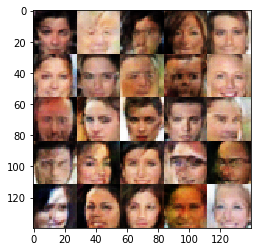

Epoch 1/1... Discriminator Loss: 1.7590... Generator Loss: 0.3946
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.3684
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 2.8234
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 1.8065
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.2698
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 1.9502


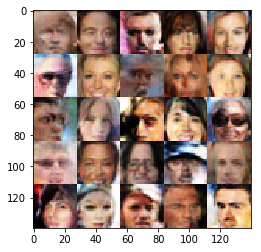

Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 1.3593
Epoch 1/1... Discriminator Loss: 1.7453... Generator Loss: 2.8624
Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.4612


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.